In [137]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GEMINI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


In [138]:
api_key = os.getenv("GEMINI_API_KEY")


In [139]:
os.environ["USER_AGENT"] = "my_agent_identifier"


In [141]:
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader, AsyncHtmlLoader
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

# Tavily tool
tavily_tool = TavilySearchResults(max_results=5)

# web scraper tool
@tool
def scrape_webpages(url: List[str]) -> str:
    """Scrape webpages with proper headers"""

    headers = {"User-Agent": os.environ["USER_AGENT"]}
    loader = WebBaseLoader(url, header_template=headers)

    try:
        docs = loader.load()
        return "\n\n".join([doc.page_content for doc in docs])
    except Exception as e:
        return f"Scraping Failed: {str(e)}"



In [142]:
from langchain_experimental.utilities import PythonREPL
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from pydantic import BaseModel, Field

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


class OutlinePointModel(BaseModel):
    """Model for defining points in the create_outline tool."""
    point: str = Field(..., description="A main poin or section for the outline.")

# This tool is create the outline for the document
@tool
def create_outline(points: Annotated[List[OutlinePointModel],"List of main points or sections"], file_name: Annotated[str,"File path to save the outline"]) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save and outline."""
    with(WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i+1}. {point.point}\n")
    return f"Outline saved to {file_name}"

# Read tool
@tool
def read_document(file_name: Annotated[str, "File path to read the document from."], start: Annotated[Optional[int], "The start line. Default is 0"] = None, end: Annotated[Optional[int], "The end line. Default is None"] = None,) -> str:
    """Read the specified document."""
    with(WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(content: Annotated[str, "Text content to be written into the document."],file_name: Annotated[str, "File path to save the document."],) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


class InsertModel(BaseModel):
    """Model for defining inserts in the edit_document tool."""
    line_number: int = Field(..., description="The line number (1-indexed) where the text should be inserted.")
    text: str = Field(..., description="The text to insert at the specified line number.")

# The edit tool which is edit the document on specific line 
@tool
def edit_document(file_name: Annotated[str, "Path of the document to be edited."],inserts: Annotated[List[InsertModel],"List of inserts, where each insert specifies a line number and text to insert.",],) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts, key=lambda x: x.line_number)

    for insert in sorted_inserts:
        if 1 <= insert.line_number <= len(lines) + 1:
            lines.insert(insert.line_number - 1, insert.text + "\n")
        else:
            return f"Error: Line number {insert.line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"



# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."],):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [143]:
from typing import List, Optional, Literal, Dict
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from pydantic import BaseModel, Field


class State(MessagesState):
    next: str
    messages: List[Dict]

# Router 
class Router(BaseModel):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: str = Field(..., description="Next worker to route to or FINISH")
   
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        f"You are a supervisor managing workers: {', '.join(members)}. "
        "Decide which worker should act next or FINISH. Respond with ONLY the worker's name."
    )
    
    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        # messages = [
        #     {"role": "system", "content": system_prompt},
        # ] + state["messages"]
        messages = [{"role": "system", "content": system_prompt}] + [
            msg if isinstance(msg, dict) else {"role": "user", "content": str(msg)}
            for msg in state["messages"]
        ]
        
        # Get raw response
        response = llm.invoke(messages).content
        
        # Simple validation
        goto = response.strip()
        if goto == "FINISH":
            return Command(goto=END, update={"next": END})
        elif goto in members:
            return Command(goto=goto, update={"next": goto})
        else:
            # Fallback to supervisor decision
            return Command(goto="supervisor", update={"messages": [HumanMessage(content=f"Invalid choice {goto}. Choose from {options}")]})
    
    return supervisor_node    


In [144]:
from langchain_core.messages import HumanMessage
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    api_key=os.environ["GEMINI_API_KEY"]
)

# Search agent which is use the tavily tool
search_agent = create_react_agent(llm, tools=[tavily_tool])

# node of search agent
def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

# web scaper agent
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done same as tavily tool
        goto="supervisor",
    )
# Here is the main agent which is supevsior who is have control in both agents
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [145]:
# Here we create the Researcher agents 

research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()


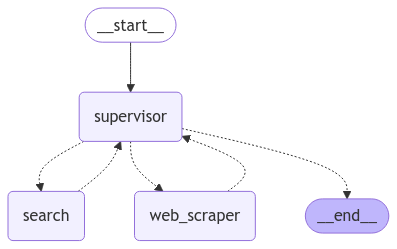

In [123]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [124]:
for s in research_graph.stream(
    {"messages": [("user", "What is  AI")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content="AI stands for Artificial Intelligence.  It's a broad field encompassing the development of computer systems able to perform tasks that typically require human intelligence.  These tasks include things like learning, reasoning, problem-solving, perception, and natural language understanding.\n", additional_kwargs={}, response_metadata={}, name='search')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [146]:
# Now Creating the writer Agents That Handle writing, reading and edithing and outline content
from tenacity import retry, stop_after_attempt, wait_exponential


llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    api_key=os.environ["GEMINI_API_KEY"]
)

# The agent which is responsible for writing reading and editing
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You are a document writer. Use the tools provided to create, edit, or read documents. "
        "Do not ask follow-up questions. Once the task is complete, respond with 'Task completed.'"
    ),
)


@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
def safe_invoke(agent, state):
    return agent.invoke(state)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    try:
        result = safe_invoke(doc_writer_agent, state)
        response = result["messages"][-1].content

        if "Task completed" in response:
            return Command(
                update={"messages": [HumanMessage(content=response, name="doc_writer")]},
                goto="supervisor",
            )
        else:
            return Command(
                update={"messages": [HumanMessage(content=response, name="doc_writer")]},
                goto="supervisor",
            )
    except Exception as e:
        return Command(
            update={"messages": [HumanMessage(content=f"Error: {str(e)}", name="doc_writer")]},
            goto="supervisor",
        )

# note taking agent which is responsible to read document and write the outline for the doc_writer_agent
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

# Node of note taking agent
def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

# Chart Generation Agent Which is responsible to generate charts like line chart bar etc..
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

# Its the Main Incharge Agent who will manage all other agents of the writing team
doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [147]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

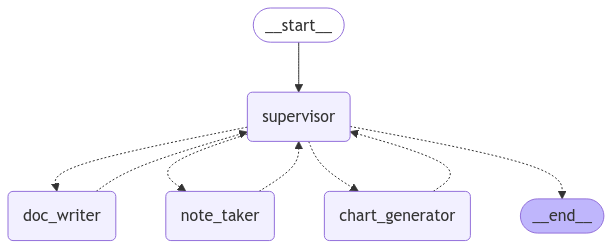

In [130]:
display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))


In [131]:
for s in paper_writing_graph.stream(
    {"messages": [("user", "Write a paragraph about AI")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='Task completed.\n', additional_kwargs={}, response_metadata={}, name='doc_writer')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [148]:
# ADD LAYER
# Now The both Graph is working fine but how to route between them? So Actually we need A Third Graph which is Actuall 
# A Super Manager that controls the both supervisors_team which is research_team, and writing_team 

# but before creating anything first create the team supervisor node so the Manager will knows
# team supervisor node
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

# First Call the Research team
def call_research_team(state: State) -> Command[Literal["manager"]]:
    # response = research_graph.invoke({"messages": state["messages"][-1]})
    last_message = state["messages"][-1].content if state["messages"] else ""

    response = research_graph.invoke({"messages": [HumanMessage(content=last_message)]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="manager",
    )

# The writing team
def call_paper_writing_team(state: State) -> Command[Literal["manager"]]:
    # response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    last_message = state["messages"][-1].content if state["messages"] else ""
    response = paper_writing_graph.invoke({"messages": [HumanMessage(content=last_message)]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="manager",
    ) 
# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("manager", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "manager")
super_graph = super_builder.compile()

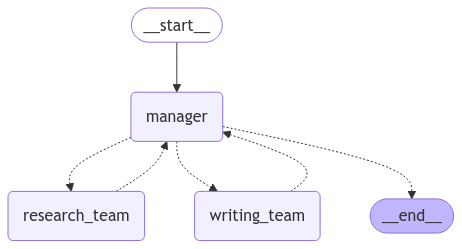

In [149]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [150]:
# In your super_graph.stream() call:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(content="what is AI and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'manager': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='AI stands for Artificial Intelligence.  It\'s a broad field encompassing the development of computer systems capable of performing tasks that typically require human intelligence.  These tasks include learning, reasoning, problem-solving, perception, and natural language understanding.\n\nA brief report on AI could cover these key aspects:\n\n**1. Defining AI:**  AI systems are designed to mimic cognitive functions associated with the human mind, such as learning from data, adapting to new situations, and making decisions.  There\'s no single, universally accepted definition, as the field is constantly evolving.\n\n**2. Types of AI:** AI can be categorized in several ways, including:\n\n* **Narrow or Weak AI:** Designed for specific tasks, like playing chess or recommending products.  Most current AI systems fall into this category.\n* **General or Strong AI:** Hypothetical AI with human-le